In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from xgboost import XGBRegressor
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import cross_val_score
import optuna
import warnings
warnings.filterwarnings("ignore")

# Loading data

In [116]:
car=pd.read_csv("car_price_prediction_.csv")
car 

,Car ID,Brand,Year,Engine Size,Fuel Type,Transmission,Mileage,Condition,Price,Model
0,1,Tesla,2016,2.3,Petrol,Manual,114832,New,26613.92,Model X
1,2,BMW,2018,4.4,Electric,Manual,143190,Used,14679.61,5 Series
2,3,Audi,2013,4.5,Electric,Manual,181601,New,44402.61,A4
3,4,Tesla,2011,4.1,Diesel,Automatic,68682,New,86374.33,Model Y
4,5,Ford,2009,2.6,Diesel,Manual,223009,Like New,73577.10,Mustang
...,...,...,...,...,...,...,...,...,...,...
2495,2496,Audi,2020,2.4,Petrol,Automatic,22650,Like New,61384.10,Q5
2496,2497,Audi,2001,5.7,Hybrid,Manual,77701,Like New,24710.35,A3
2497,2498,Ford,2021,1.1,Hybrid,Manual,272827,Like New,29902.45,Fiesta
2498,2499,Audi,2002,4.5,Diesel,Manual,229164,Like New,46085.67,Q5


In [117]:
car.drop(["Car ID"],axis=1,inplace=True)  # Dropping id columns no use

In [118]:
car.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Brand         2500 non-null   object 
 1   Year          2500 non-null   int64  
 2   Engine Size   2500 non-null   float64
 3   Fuel Type     2500 non-null   object 
 4   Transmission  2500 non-null   object 
 5   Mileage       2500 non-null   int64  
 6   Condition     2500 non-null   object 
 7   Price         2500 non-null   float64
 8   Model         2500 non-null   object 
dtypes: float64(2), int64(2), object(5)
memory usage: 175.9+ KB


In [119]:
# Checking for null values and duplicates
car.isna().sum().sum(),car.duplicated().sum()

(np.int64(0), np.int64(0))

In [120]:
for col in ["Brand","Fuel Type","Transmission","Condition"]:
    Y=car[col].value_counts()
    print(f"❄️ Data Distribution of {col}",Y)

❄️ Data Distribution of Brand Brand
Toyota      374
Audi        368
BMW         358
Mercedes    353
Honda       352
Tesla       348
Ford        347
Name: count, dtype: int64
❄️ Data Distribution of Fuel Type Fuel Type
Diesel      655
Petrol      630
Electric    614
Hybrid      601
Name: count, dtype: int64
❄️ Data Distribution of Transmission Transmission
Manual       1308
Automatic    1192
Name: count, dtype: int64
❄️ Data Distribution of Condition Condition
Used        855
Like New    836
New         809
Name: count, dtype: int64


In [121]:
car["Model"].value_counts() #Good Distribution

Model
Fiesta      103
Corolla     103
A3           98
A4           96
Q7           95
CR-V         95
5 Series     93
3 Series     93
Prius        93
Model X      93
C-Class      92
X3           92
GLA          92
Camry        90
E-Class      89
Fit          89
Model Y      89
RAV4         88
Accord       88
Model 3      87
Explorer     86
Focus        81
Civic        80
X5           80
GLC          80
Q5           79
Model S      79
Mustang      77
Name: count, dtype: int64

# Visualizing data

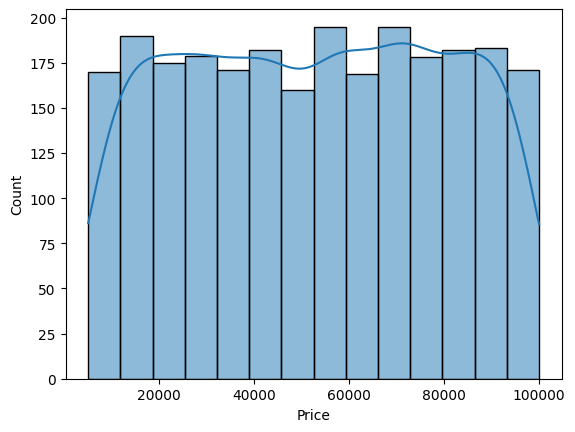

In [122]:
sns.histplot(data=car,x="Price",kde=True)
plt.show()

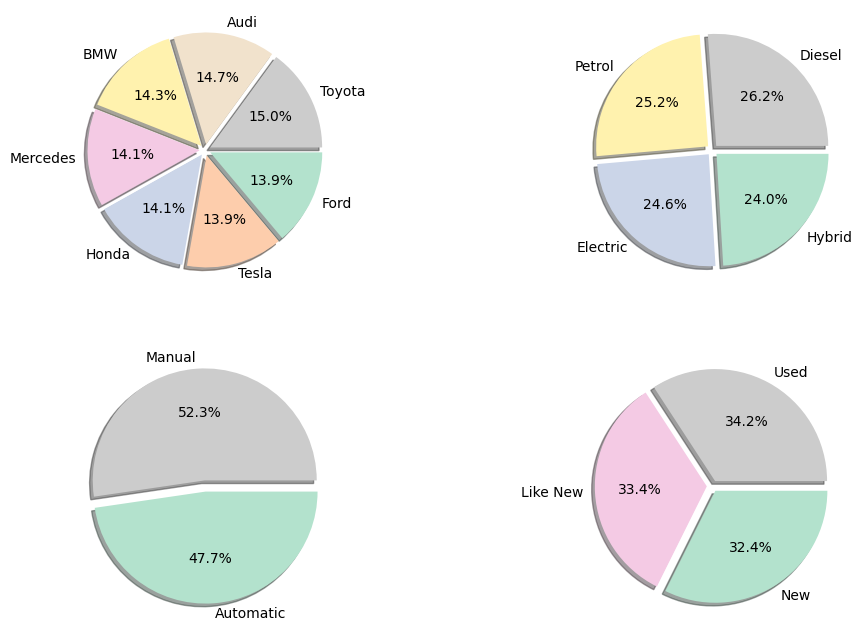

In [123]:
# Pie distribution and count
fig,ax=plt.subplots(2,2,figsize=(12,8))
cmap = plt.get_cmap("Pastel2_r")

#For brand
d1=car["Brand"].value_counts()
d1_color = cmap(np.linspace(0, 1, len(d1)))
ax[0,0].pie(d1,autopct="%1.1f%%",explode=[0.05]*len(d1),shadow=True,colors=d1_color,labels=d1.index)

#for Fuel Type
d2=car["Fuel Type"].value_counts()
d2_color = cmap(np.linspace(0, 1, len(d2)))
ax[0,1].pie(d2,autopct="%1.1f%%",explode=[0.05]*len(d2),shadow=True,colors=d2_color,labels=d2.index)

# Transmission
d3=car["Transmission"].value_counts()
d3_color = cmap(np.linspace(0, 1, len(d3)))
ax[1,0].pie(d3,autopct="%1.1f%%",explode=[0.05]*len(d3),shadow=True,colors=d3_color,labels=d3.index)

# Condition
d4=car["Condition"].value_counts()
d4_color = cmap(np.linspace(0, 1, len(d4)))
ax[1,1].pie(d4,autopct="%1.1f%%",explode=[0.05]*len(d4),shadow=True,colors=d4_color,labels=d4.index)
plt.show()

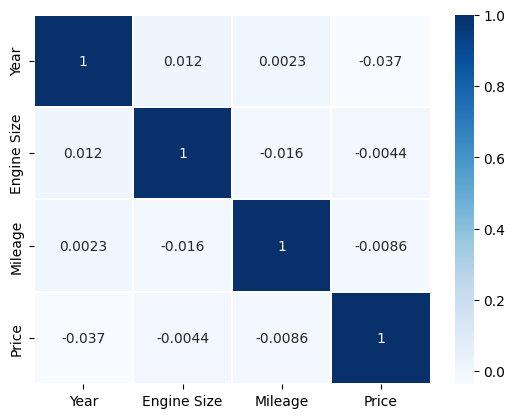

In [124]:
# Correlation of price and mileage
corr=car.select_dtypes(include=[np.number]).corr()
sns.heatmap(corr,annot=True,linewidth=0.2,cmap="Blues")
plt.show()

In [125]:
# MAKING NEW FEATURE
car["new1"]=(car["Year"]*car["Engine Size"])/(car["Mileage"]+1)
car["new2"]=car["Brand"]+"_"+car["Model"]
plt.figure(figsize=(10,6))
corr=car.select_dtypes(include=[np.number]).corr()
corr["Price"]                                        # We get a more coreelated feature

Year          -0.036805
Engine Size   -0.004420
Mileage       -0.008567
Price          1.000000
new1          -0.013286
Name: Price, dtype: float64

<Figure size 1000x600 with 0 Axes>

# Splitting and scaling Data

In [126]:
X=car.drop("Price",axis=1)
y=car["Price"]
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

# Encoding

In [127]:
num_cat=list(X_train.select_dtypes(include=[np.number]).columns)
alp_cat=[col for col in X_train.columns if col not in num_cat]

pipeline=ColumnTransformer([
    ("Scaling",StandardScaler(),num_cat),
    ("OneHot",OneHotEncoder(),alp_cat)
])

X_train=pipeline.fit_transform(X_train)
X_test=pipeline.transform(X_test)
features=num_cat+list(pipeline.named_transformers_["OneHot"].get_feature_names_out(alp_cat))

# Evaluation Fuction

In [128]:
def eval_model(model,features):
    results=cross_validate(model,X_train,y_train,cv=10,
                          scoring=["neg_mean_squared_error","r2"],return_train_score=True)
    mse=-results["test_neg_mean_squared_error"].mean()
    r2=results["test_r2"].mean()
    print(f"✅ Root Mean squared error of {model.__class__.__name__} is : ",np.sqrt(mse))
    print(f"✅ R2 score of {model.__class__.__name__} is : ",r2)

    if hasattr(model,"feature_importances_"):
        df=pd.DataFrame({"Imp":model.feature_importances_,
                         "Name":features}).sort_values("Imp",ascending=False)
        sns.barplot(data=df.head(10),x="Imp",y="Name",palette="summer")
        plt.title("Top 10 Features")
        plt.show()

# Xgboost

✅ Root Mean squared error of XGBRegressor is :  31181.62032487516
✅ R2 score of XGBRegressor is :  -0.3189627734842214


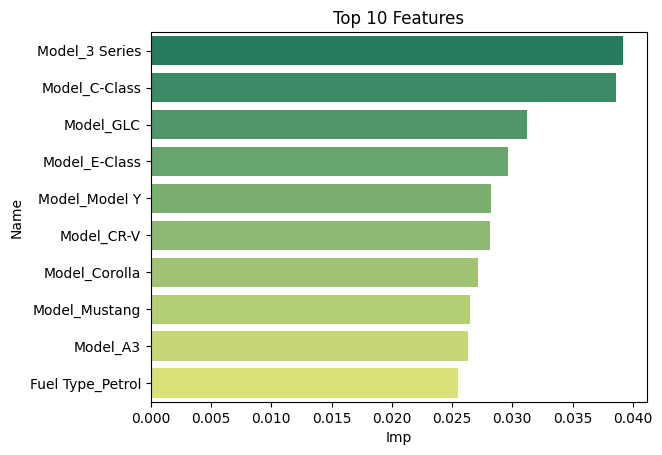

In [129]:
xgb_reg=XGBRegressor()
xgb_reg.fit(X_train,y_train)
eval_model(xgb_reg,features)

# Light Boost

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000198 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 731
[LightGBM] [Info] Number of data points in the train set: 2000, number of used features: 76
[LightGBM] [Info] Start training from score 52461.688673
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000152 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 731
[LightGBM] [Info] Number of data points in the train set: 1800, number of used features: 76
[LightGBM] [Info] Start training from score 52282.648904
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000172 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 731
[LightGBM] [Info] Number of data points in the train set: 1800, number of used features: 76
[LightGBM] [Info] Start t

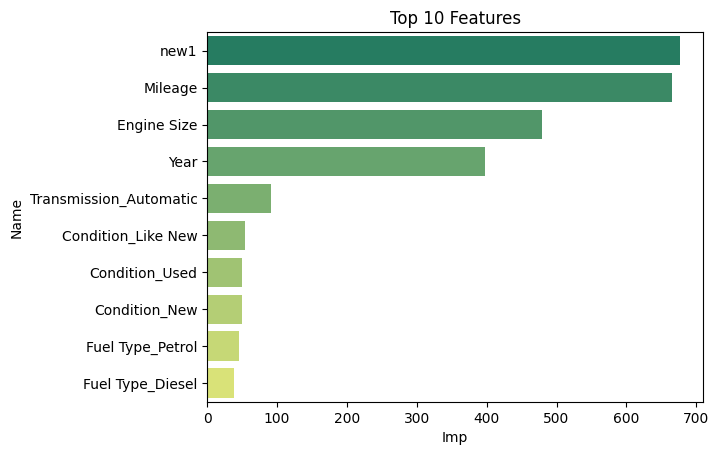

In [130]:
lgbm_reg=LGBMRegressor()
lgbm_reg.fit(X_train,y_train)
eval_model(lgbm_reg,features)

# SVR

In [131]:
svr_reg=SVR()
svr_reg.fit(X_train,y_train)
eval_model(svr_reg,features)

✅ Root Mean squared error of SVR is :  27262.188847931404
✅ R2 score of SVR is :  -0.00721494249865271


# HyperParameter Tuning using Optuna

In [66]:
def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 100, 1000)
    max_depth = trial.suggest_int("max_depth", 3, 20)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.2)
    subsample = trial.suggest_float("subsample", 0.5, 1.0)                
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.5, 1.0)    
    min_child_weight = trial.suggest_int("min_child_weight", 1, 10)         
    gamma = trial.suggest_float("gamma", 0.0, 5.0)                          
    reg_alpha = trial.suggest_float("reg_alpha", 0.0, 10.0)                 
    reg_lambda = trial.suggest_float("reg_lambda", 0.0, 10.0)               
    scale_pos_weight = trial.suggest_float("scale_pos_weight", 0.5, 5.0)

    
    model=XGBRegressor(n_estimators=n_estimators,
                      max_depth=max_depth,
                      learning_rate=learning_rate,
                      subsample=subsample,
                      min_child_weight=min_child_weight,
                      gamma=gamma,
                      reg_alpha=reg_alpha,
                      reg_lambda=reg_lambda,
                      scale_pos_weight=scale_pos_weight)

    score=cross_val_score(model,X_train,y_train,cv=3,scoring="neg_mean_squared_error",n_jobs=-1).mean()

    return score

In [67]:
study=optuna.create_study(direction="maximize")
study.optimize(objective,n_trials=200)

[I 2025-08-26 08:17:51,535] A new study created in memory with name: no-name-12ec9f84-09d8-470e-a50d-dff5bc62d9b0
[I 2025-08-26 08:17:53,432] Trial 0 finished with value: -766518791.0653814 and parameters: {'n_estimators': 140, 'max_depth': 3, 'learning_rate': 0.04550843034177712, 'subsample': 0.9283199530020485, 'colsample_bytree': 0.8631271564126222, 'min_child_weight': 6, 'gamma': 1.4066617361935312, 'reg_alpha': 3.340059121566976, 'reg_lambda': 3.1351545883440335, 'scale_pos_weight': 1.8975032251982675}. Best is trial 0 with value: -766518791.0653814.
[I 2025-08-26 08:17:55,221] Trial 1 finished with value: -993844533.0712324 and parameters: {'n_estimators': 457, 'max_depth': 15, 'learning_rate': 0.18324871982212232, 'subsample': 0.7837080953984721, 'colsample_bytree': 0.6697087714360844, 'min_child_weight': 9, 'gamma': 3.950671910350085, 'reg_alpha': 7.78701627526352, 'reg_lambda': 5.625270500890908, 'scale_pos_weight': 1.2004411902745598}. Best is trial 0 with value: -766518791.0

In [68]:
study.best_params

{'n_estimators': 101,
 'max_depth': 3,
 'learning_rate': 0.014645901397046718,
 'subsample': 0.505426778787415,
 'colsample_bytree': 0.9610662976530825,
 'min_child_weight': 10,
 'gamma': 1.622554131693049,
 'reg_alpha': 4.583460126701454,
 'reg_lambda': 6.64224069041535,
 'scale_pos_weight': 3.1489910291230507}

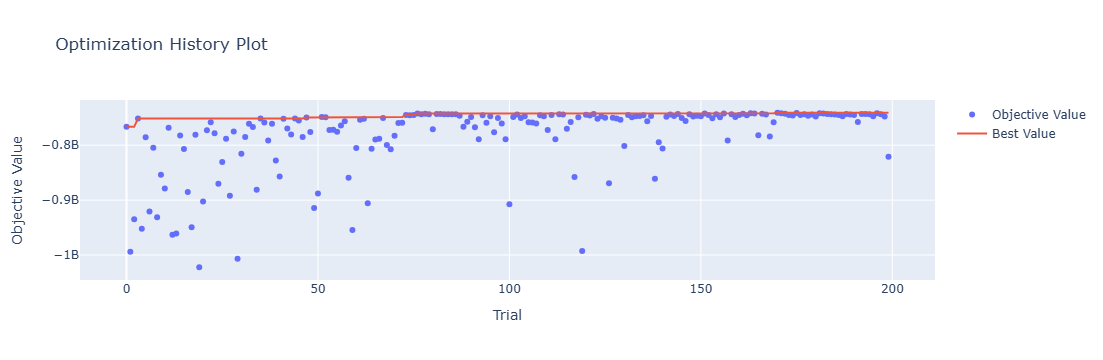

<Figure size 1200x2000 with 0 Axes>

In [69]:
plt.figure(figsize=(12,20))
optuna.visualization.plot_optimization_history(study)

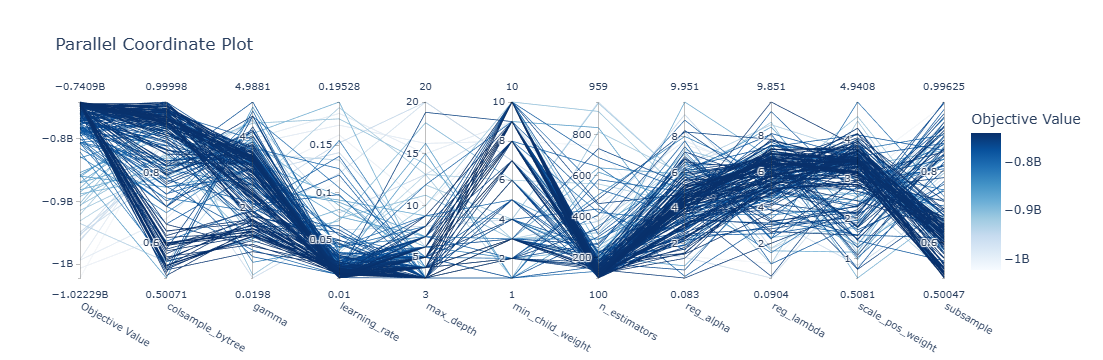

In [70]:
optuna.visualization.plot_parallel_coordinate(study)

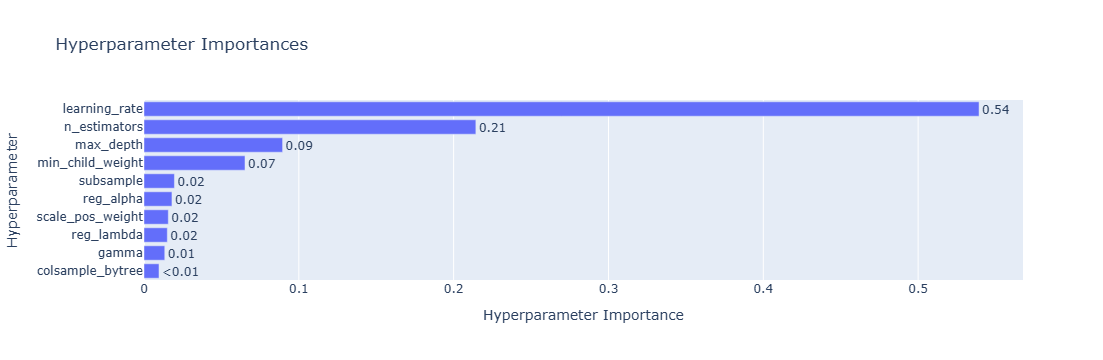

In [71]:
optuna.visualization.plot_param_importances(study)

In [73]:
best_param=study.best_params

✅ Root Mean squared error of XGBRegressor is :  27247.390236473577
✅ R2 score of XGBRegressor is :  -0.005746366404702163


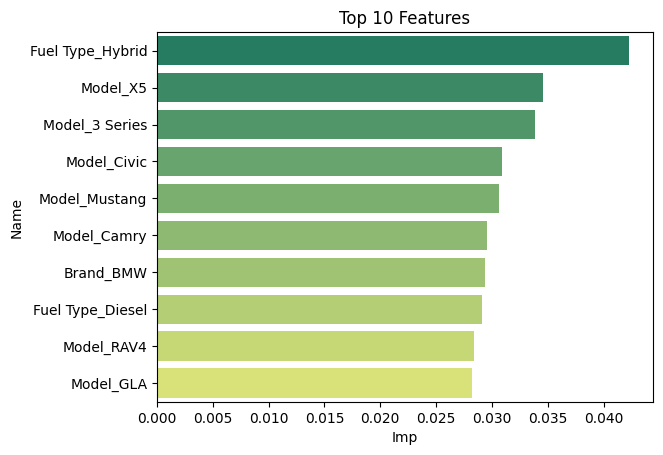

In [77]:
tuned_model=XGBRegressor(**best_param)
tuned_model.fit(X_train,y_train)
eval_model(tuned_model,features)

# On test Data

In [80]:
predictions=tuned_model.predict(X_test)
mse=mean_squared_error(y_test,predictions)
r2=r2_score(y_test,predictions)
print("🏹 Root Mean Sqauare Error is : ",np.sqrt(mse))
print("🔥R2 Score is :",r2)

🏹 Root Mean Sqauare Error is :  27491.666693197614
🔥R2 Score is : 0.0023253738568274063
